In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import pmf_from_dist, plot_cdf, plot_pred

In [4]:
import pymc3 as pm
import arviz as az

In [5]:
alpha = 1.4
beta = 1
prior_dist = ss.gamma(alpha, scale=1/beta)

In [6]:
lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)
data = 4
likelihood = ss.poisson(lams).pmf(data)
posterior = prior_pmf * likelihood
posterior.normalize()
posterior

,probs
0.0,0.000000
0.1,0.000003
0.2,0.000053
0.3,0.000260
0.4,0.000755
...,...
9.6,0.000009
9.7,0.000008
9.8,0.000007
9.9,0.000006


<AxesSubplot:>

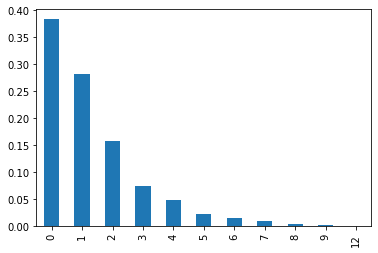

In [13]:
# 사전표본
sample_prior = prior_dist.rvs(1000)
# 사전표본에 대한 포아송 분포의 표본..? 이걸 책에서는 사전예측분포라고 표현
# rvs(mu, size=1) 메서드는 mu일 때 확률분포로 size만큼 생성
sample_prior_pred = ss.poisson.rvs(sample_prior)
pmf_prior_pred = Pmf.from_seq(sample_prior_pred)
pmf_prior_pred.plot.bar()

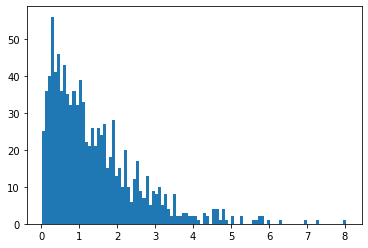

In [26]:
# 참고: 사전표본의 감마분포 확인을 위한 히스토그램 작업
sample_prior_copy = sample_prior.copy()
sample_prior_copy.sort()
plt.hist(sample_prior_copy, bins=100)
plt.show()

In [31]:
with pm.Model() as model:
    # 사전분포인 감마분포를 생성
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    # Poisson(mu=lam)을 가지는 사전예측분포 생성
    goals = pm.Poisson('goals', lam)

In [32]:
goals

goals ~ Poisson

In [35]:
with model:
    # 사전분포에서의 lam에 대한 표본..?
    # 위에서의 prior_dist(rvs)(trace['lam']) + ss.poisson.rvs(sample_prior)(trace['goal']와 같은 개념
    trace = pm.sample_prior_predictive(1000)

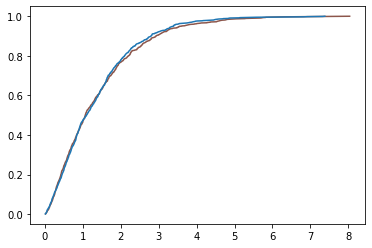

In [36]:
sample_prior_pymc = trace['lam']
plot_cdf(sample_prior, label='SciPy sample', color='C5')
plot_cdf(sample_prior_pymc, label='PyMC3 sample', color='C0')

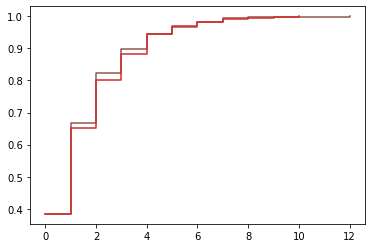

In [37]:
sample_prior_pred_pymc = trace['goals']
plot_pred(sample_prior_pred, label='SciPy sample', color='C5')
plot_pred(sample_prior_pred_pymc, label='PyMC3 sample', color='C13')

In [38]:
with pm.Model() as model2:
    # 사전분포인 감마분포를 생성
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    # observed 매개변수를 넣어 사후예측분포 생성
    goals = pm.Poisson('goals', lam, observed=4)

In [39]:
options = dict(return_inferencedata=False)
with model2:
    # 사후분포로부터 표본을 가져오는 형태
    # 1,000개의 표본에 대한 두 개의 값을 만든 후, 절반을 버리고 남은 1,000개를 반환
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


In [40]:
sample_post_pymc = trace2['lam']
sample_post_pymc.shape

(2000,)

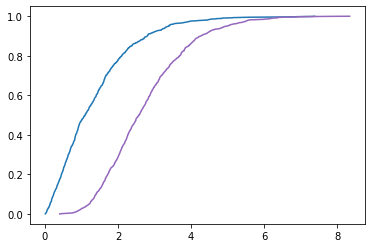

In [41]:
plot_cdf(sample_prior_pymc, label='PyMC3 sample', color='C0')
plot_cdf(sample_post_pymc, label='PyMC3 sample', color='C4')